In [1]:
root_dir='../input/taiwanese-food-101/tw_food_101/tw_food_101'
train_data_dir = root_dir+'/train'
validation_data_dir= root_dir

In [2]:
n_classes = 101
img_width, img_height = 150, 150
# There are 20,372 training images and 5,093 test images.
nb_train_samples = 20372 
nb_validation_samples = 5093
batch_size = 16

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 20372 images belonging to 101 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 20372 images belonging to 101 classes.


In [7]:
import keras
# include_top=False → We want to remove the top classifiers, and reuse only the convolution base. So to reuse the model, we need to set the include_top to false.
base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
# Freeze the parameters in the model, because we want to reduce the weights. To freeze the parameters, simply set "Trainable" to "Force".  If set the model "Trainable" to "Force", then Keras will freeze the parameters. If not freeze the parameters, then overfitting.  
base_model.trainable = False

29097984/29084464 [==============================] - 0s 0us/step


In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(101, activation='softmax')(x)

model = keras.Model(inputs = base_model.input, outputs=predictions )

In [9]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train_generator,batch_size=16,
                    validation_data=validation_generator,
                    epochs=10,
                    )

Epoch 1/10
  49/1274 [>.............................] - ETA: 7:31 - loss: 6.6667 - accuracy: 0.0281

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 388/1274 [========>.....................] - ETA: 5:26 - loss: 4.5069 - accuracy: 0.0594

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1274/1274 [==============================] - 823s 637ms/step - loss: 3.7636 - accuracy: 0.1295 - val_loss: 2.7475 - val_accuracy: 0.2796
Epoch 2/10
1274/1274 [==============================] - 687s 540ms/step - loss: 2.8907 - accuracy: 0.2706 - val_loss: 2.3254 - val_accuracy: 0.3794
Epoch 3/10
1274/1274 [==============================] - 727s 571ms/step - loss: 2.6770 - accuracy: 0.3144 - val_loss: 2.1908 - val_accuracy: 0.4076
Epoch 4/10
1274/1274 [==============================] - 683s 536ms/step - loss: 2.5497 - accuracy: 0.3393 - val_loss: 2.2333 - val_accuracy: 0.4028
Epoch 5/10
1274/1274 [==============================] - 679s 533ms/step - loss: 2.4887 - accuracy: 0.3567 - val_loss: 2.1451 - val_accuracy: 0.4240
Epoch 6/10
1274/1274 [==============================] - 678s 533ms/step - loss: 2.4565 - accuracy: 0.3631 - val_loss: 2.1288 - val_accuracy: 0.4365
Epoch 7/10
1274/1274 [==============================] - 680s 534ms/step - loss: 2.4247 - accuracy: 0.3672 - val_loss: 2.026

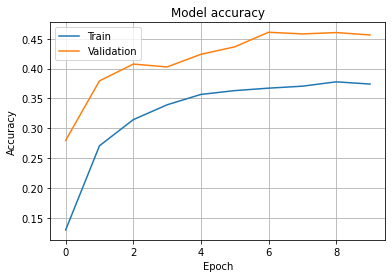

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

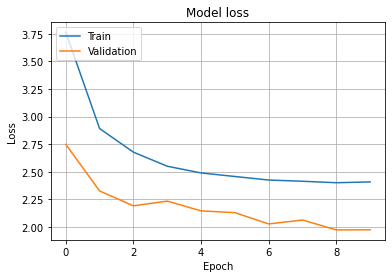

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [13]:
import os
test_dict = {}
for root, dirs, files in os.walk(validation_data_dir + '/test/'):
    for filename in files:
        test_id, file_ext = os.path.splitext(filename)
        test_dict[test_id] = filename

In [14]:
from skimage import transform
from PIL import Image
def load_img(filename, target_w=150, target_h=150):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (target_w, target_h, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [15]:
import numpy as np
results = []
for i in range(len(test_dict)):
    img = load_img(validation_data_dir + '/test/' + test_dict[str(i)], 150, 150)
    ret = model.predict(img)
    results.append(np.argmax(ret))

In [16]:
with open('pred_results.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(results)):
        f.write(str(i) + ',' + str(results[i]) + '\n')

In [17]:
from IPython.display import FileLink
FileLink('pred_results.csv')

/kaggle/working/pred_results.csv

In [18]:
#Fine-Tuning
# In order to get better accuray, chnage some parameters of the pre-trained model, called "fine-tuning".
# Usually only tune the top-layers, because the lower layer capture the more fundamental features, and the top layers capture the more semantic features, which we may want to fine-tune for our specific tasks.
from tensorflow import keras
base_model.trainable = True
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.00001), 
                        loss='categorical_crossentropy', metrics=['accuracy'])


# history = model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.00001), 
#                         loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_generator,batch_size=16,
                    validation_data=validation_generator,
                    epochs=10,
                    )

Epoch 1/10
1274/1274 [==============================] - 737s 565ms/step - loss: 3.0652 - accuracy: 0.2736 - val_loss: 2.1512 - val_accuracy: 0.4332
Epoch 2/10
1274/1274 [==============================] - 715s 561ms/step - loss: 2.5360 - accuracy: 0.3500 - val_loss: 1.8411 - val_accuracy: 0.5005
Epoch 3/10
1274/1274 [==============================] - 719s 564ms/step - loss: 2.3437 - accuracy: 0.3882 - val_loss: 1.6780 - val_accuracy: 0.5379
Epoch 4/10
1274/1274 [==============================] - 722s 567ms/step - loss: 2.2226 - accuracy: 0.4202 - val_loss: 1.5771 - val_accuracy: 0.5578
Epoch 5/10
1274/1274 [==============================] - 718s 564ms/step - loss: 2.1005 - accuracy: 0.4427 - val_loss: 1.4801 - val_accuracy: 0.5790
Epoch 6/10
1274/1274 [==============================] - 722s 567ms/step - loss: 2.0286 - accuracy: 0.4608 - val_loss: 1.4034 - val_accuracy: 0.5966
Epoch 7/10
1274/1274 [==============================] - 723s 567ms/step - loss: 1.9519 - accuracy: 0.4789 - val_

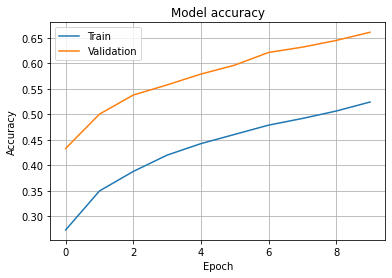

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

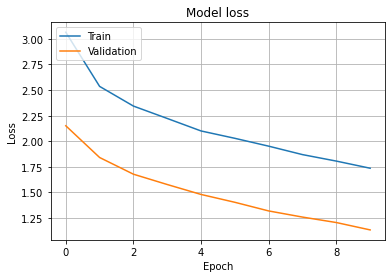

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [22]:
import os
test_dict = {}
for root, dirs, files in os.walk(validation_data_dir + '/test/'):
    for filename in files:
        test_id, file_ext = os.path.splitext(filename)
        test_dict[test_id] = filename

In [23]:
from skimage import transform
from PIL import Image
def load_img(filename, target_w=150, target_h=150):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (target_w, target_h, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [24]:
import numpy as np
results = []
for i in range(len(test_dict)):
    img = load_img(validation_data_dir + '/test/' + test_dict[str(i)], 150, 150)
    ret = model.predict(img)
    results.append(np.argmax(ret))

In [25]:
with open('pred_results.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(results)):
        f.write(str(i) + ',' + str(results[i]) + '\n')

In [26]:
from IPython.display import FileLink
FileLink('pred_results.csv')

/kaggle/working/pred_results.csv

改用"optimizer='rmsprop'

變爛了，Score down to 0.01571.

In [33]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# history = model.fit(train_generator,batch_size=16,
#                     validation_data=validation_generator,
#                     epochs=5,
#                     )

In [29]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.grid(True)
# plt.show()

In [30]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.grid(True)
# plt.show()

In [31]:
# results = []
# for i in range(len(test_dict)):
#     img = load_img(validation_data_dir + '/test/' + test_dict[str(i)], 150, 150)
#     ret = model.predict(img)
#     results.append(np.argmax(ret))

In [32]:
# with open('pred_results.csv', 'w') as f:
#     f.write('Id,Category\n')
#     for i in range(len(results)):
# #         f.write(str(i) + ',' + str(results[i]) + '\n')
# FileLink('pred_results.csv')